

# 1. **Problem Description**
# 2. **Load and Prepare Dataset**
# 3. **Model Evaluation**
# 4. **LSTMs for Multi-Step Forecasting**
# 5. **LSTM Model With Univariate Input and Vector Output**
# 6. **Encoder-Decoder LSTM Model With Univariate Input**
# 7. **Encoder-Decoder LSTM Model With Multivariate Input**
# 8. **CNN-LSTM Encoder-Decoder Model With Univariate Input**
# 9. **ConvLSTM Encoder-Decoder Model With Univariate Input**





In [ ]:
# load all data
#load the data and combine the first two columns into a single date-time column that we can use as an index.
import pandas as pd 
dataset = pd.read_csv('/content/drive/MyDrive/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [ ]:
# mark all missing values 
#we can mark all missing values indicated with a ‘?‘ character with a NaN value, which is a float.
from numpy import nan
dataset.replace('?', nan, inplace=True)
# make dataset numeric
#This will allow us to work with the data as one array of floating point values rather than mixed types (less efficient.)
dataset = dataset.astype('float32')

In [ ]:
# fill missing values with a value at the same time one day ago
def fill_missing(values):
	one_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]

In [ ]:
# fill missing
from math import isnan
fill_missing(dataset.values)

In [ ]:
# add a column for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

In [ ]:
# save updated dataset
dataset.to_csv('/content/drive/MyDrive/household_power_consumption.csv')

# **Model Evaluation**

# 1.   Problem Framing
# 2.   Evaluation Metric
# 3.   Train and Test Sets
# 4.   Walk-Forward Validation




* Framing of the dataset useful to downsample the per-minute observations of power consumption to daily totals.

In [ ]:
# resample minute data to total for each day
from pandas import read_csv
# load the new file
dataset = read_csv('/content/drive/MyDrive/household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  ...  sub_metering_4
datetime                         ...                
2006-12-16             1209.176  ...    14680.933319
2006-12-17             3390.460  ...    36946.666732
2006-12-18             2203.826  ...    19028.433281
2006-12-19             1666.194  ...    13131.900043
2006-12-20             2225.748  ...    20384.800011

[5 rows x 8 columns]


In [ ]:
dataset.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011


**The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute.**

**It is a multivariate series comprised of seven variables (besides the date and time); they are:**

**global_active_power:** The total active power consumed by the household (kilowatts).
**global_reactive_power:** The total reactive power consumed by the household (kilowatts).
**voltage:** Average voltage (volts).
**global_intensity:** Average current intensity (amps).
**sub_metering_1:** Active energy for kitchen (watt-hours of active energy).
**sub_metering_2:** Active energy for laundry (watt-hours of active energy).
**sub_metering_3:** Active energy for climate control systems (watt-hours of active energy).

* Evaluation Metric


In [ ]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

* Train and Test Sets

We will use the first 3 years of data for training predictive models and the final year for evaluating models.

In [ ]:
# # split into standard weeks
# from numpy import split
# from numpy import array
# from pandas import read_csv

# # split a univariate dataset into train/test sets
# def split_dataset(data):
# 	# split into standard weeks
# 	train, test = data[1:-328], data[-328:-6]
# 	# restructure into windows of weekly data
# 	train = array(split(train, len(train)/7))
# 	test = array(split(test, len(test)/7))
# 	return train, test

# # load the new file
# dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# train, test = split_dataset(dataset.values)
# # validate train data
# print(train.shape)
# print(train[0, 0, 0], train[-1, -1, 0])
# # validate test
# print(test.shape)
# print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.2679999999998
(46, 7, 8)
2083.4539999999984 2197.006000000004


* Walk-Forward Validation

This is where a model is required to make a one week prediction, then the actual data for that week is made available to the model so that it can be used as the basis for making a prediction on the subsequent week. This is both realistic for how the model may be used in practice and beneficial to the models allowing them to make use of the best available data.

exemple : 

Input    | 		Predict


[Week1]	 |					Week2


[Week1 + Week2]	|			Week3


[Week1 + Week2 + Week3]	|	Week4
...

* We are working with neural networks, and as such, they are generally slow to train but fast to evaluate. This means that the preferred usage of the models is to build them once on historical data and to use them to forecast each step of the walk-forward validation. The models are static (i.e. not updated) during their evaluation.

In [ ]:
# # evaluate a single model
# def evaluate_model(train, test, n_input):
# 	# fit model
# 	model = build_model(train, n_input)
# 	# history is a list of weekly data
# 	history = [x for x in train]
# 	# walk-forward validation over each week
# 	predictions = list()
# 	for i in range(len(test)):
# 		# predict the week
# 		yhat_sequence = forecast(model, history, n_input)
# 		# store the predictions
# 		predictions.append(yhat_sequence)
# 		# get real observation and add to history for predicting the next week
# 		history.append(test[i, :])
# 	# evaluate predictions days for each week
# 	predictions = array(predictions)
# 	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
# 	return score, scores

In [ ]:
# # summarize scores
# def summarize_scores(name, score, scores):
# 	s_scores = ', '.join(['%.1f' % s for s in scores])
# 	print('%s: [%.3f] %s' % (name, score, s_scores))

# LSTMs for Multi-Step Forecasting
* Recurrent neural networks, or RNN, are specifically designed to work, learn, and predict sequence data.

* A recurrent neural network is a neural network where the output of the network from one time step is provided as an input in the subsequent time step. This allows the model to make a decision as to what to predict based on both the input for the current time step and direct knowledge of what was output in the prior time step.

* Perhaps the most successful and widely used RNN is the long short-term memory network, or LSTM for short. It is successful because it overcomes the challenges involved in training a recurrent neural network, resulting in stable models. In addition to harnessing the recurrent connection of the outputs from the prior time step, LSTMs also have an internal memory that operates like a local variable, allowing them to accumulate state over the input sequence.

LSTMs offer a number of benefits when it comes to multi-step time series forecasting; they are:

 * **Native Support for Sequences**. LSTMs are a type of recurrent network, and as such are designed to take sequence data as input, unlike other models where lag observations must be presented as input features.
 * **Multivariate Inputs**. LSTMs directly support multiple parallel input sequences for multivariate inputs, unlike other models where multivariate inputs are presented in a flat structure.
 * **Vector Output**. Like other neural networks, LSTMs are able to map input data directly to an output vector that may represent multiple output time steps.

Further, specialized architectures have been developed that are specifically designed to make multi-step sequence predictions, generally referred to as sequence-to-sequence prediction, or seq2seq for short. This is useful as multi-step time series forecasting is a type of seq2seq prediction.

* Below is a function named to_supervised() that takes a list of weeks (history) and the number of time steps to use as inputs and outputs and returns the data in the overlapping moving window format.

In [ ]:
# # convert history into inputs and outputs
# def to_supervised(train, n_input, n_out=7):
# 	# flatten data
# 	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
# 	X, y = list(), list()
# 	in_start = 0
# 	# step over the entire history one time step at a time
# 	for _ in range(len(data)):
# 		# define the end of the input sequence
# 		in_end = in_start + n_input
# 		out_end = in_end + n_out
# 		# ensure we have enough data for this instance
# 		if out_end <= len(data):
# 			x_input = data[in_start:in_end, 0]
# 			x_input = x_input.reshape((len(x_input), 1))
# 			X.append(x_input)
# 			y.append(data[in_end:out_end, 0])
# 		# move along one time step
# 		in_start += 1
# 	return array(X), array(y)

* The build_model() below prepares the training data, defines the model, and fits the model on the training data, returning the fit model ready for making predictions.

In [ ]:
# # train the model
# def build_model(train, n_input):
# 	# prepare data
# 	train_x, train_y = to_supervised(train, n_input)
# 	# define parameters
# 	verbose, epochs, batch_size = 0, 70, 16
# 	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# 	# define model
# 	model = Sequential()
# 	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
# 	model.add(Dense(100, activation='relu'))
# 	model.add(Dense(n_outputs))
# 	model.compile(loss='mse', optimizer='adam')
# 	# fit network
# 	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
# 	return model


* The forecast() function below implements this and takes as arguments the model fit on the training dataset, the history of data observed so far, and the number of input time steps expected by the model.

In [ ]:
# # make a forecast
# def forecast(model, history, n_input):
# 	# flatten data
# 	data = array(history)
# 	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
# 	# retrieve last observations for input data
# 	input_x = data[-n_input:, 0]
# 	# reshape into [1, n_input, 1]
# 	input_x = input_x.reshape((1, len(input_x), 1))
# 	# forecast the next week
# 	yhat = model.predict(input_x, verbose=0)
# 	# we only want the vector forecast
# 	yhat = yhat[0]
# 	return yhat

In [ ]:
# # evaluate a single model
# def evaluate_model(train, test, n_input):
# 	# fit model
# 	model = build_model(train, n_input)
# 	# history is a list of weekly data
# 	history = [x for x in train]
# 	# walk-forward validation over each week
# 	predictions = list()
# 	for i in range(len(test)):
# 		# predict the week
# 		yhat_sequence = forecast(model, history, n_input)
# 		# store the predictions
# 		predictions.append(yhat_sequence)
# 		# get real observation and add to history for predicting the next week
# 		history.append(test[i, :])
# 	# evaluate predictions days for each week
# 	predictions = array(predictions)
# 	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
# 	return score, scores

lstm: [395.355] 417.3, 406.3, 377.3, 395.8, 407.0, 312.1, 439.1


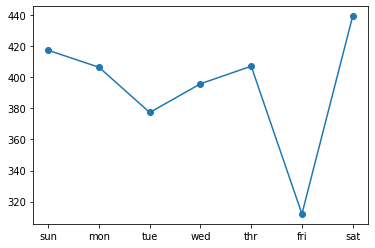

In [ ]:
# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# from matplotlib import pyplot

# # load the new file
# dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# # split into train and test
# train, test = split_dataset(dataset.values)
# # evaluate model and get scores ( gedeh theb mn jours )
# n_input = 7
# score, scores = evaluate_model(train, test, n_input)
# # summarize scores
# summarize_scores('lstm', score, scores)
# # plot scores
# days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
# pyplot.plot(days, scores, marker='o', label='lstm')
# pyplot.show()

# Encoder-Decoder LSTM Model With Univariate Input
*  we use an encoder-decoder model.This means that the model will not output a vector sequence directly. Instead, the model will be comprised of two sub models, the encoder to read and encode the input sequence, and the decoder that will read the encoded input sequence and make a one-step prediction for each element in the output sequence.
* The important difference is that an LSTM model is used in the decoder, allowing it to both know what was predicted for the prior day in the sequence and accumulate internal state while outputting the sequence.

lstm: [373.705] 370.1, 402.2, 349.0, 362.5, 388.7, 326.3, 410.0


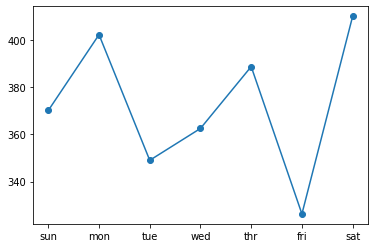

In [ ]:
# # univariate multi-step encoder-decoder lstm
# from math import sqrt
# from numpy import split
# from numpy import array
# from pandas import read_csv
# from sklearn.metrics import mean_squared_error
# from matplotlib import pyplot
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers import LSTM
# from keras.layers import RepeatVector
# from keras.layers import TimeDistributed

# # split a univariate dataset into train/test sets
# def split_dataset(data):
# 	# split into standard weeks
# 	train, test = data[1:-328], data[-328:-6]
# 	# restructure into windows of weekly data
# 	train = array(split(train, len(train)/7))
# 	test = array(split(test, len(test)/7))
# 	return train, test

# # evaluate one or more weekly forecasts against expected values
# def evaluate_forecasts(actual, predicted):
# 	scores = list()
# 	# calculate an RMSE score for each day
# 	for i in range(actual.shape[1]):
# 		# calculate mse
# 		mse = mean_squared_error(actual[:, i], predicted[:, i])
# 		# calculate rmse
# 		rmse = sqrt(mse)
# 		# store
# 		scores.append(rmse)
# 	# calculate overall RMSE
# 	s = 0
# 	for row in range(actual.shape[0]):
# 		for col in range(actual.shape[1]):
# 			s += (actual[row, col] - predicted[row, col])**2
# 	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
# 	return score, scores

# # summarize scores
# def summarize_scores(name, score, scores):
# 	s_scores = ', '.join(['%.1f' % s for s in scores])
# 	print('%s: [%.3f] %s' % (name, score, s_scores))

# # convert history into inputs and outputs
# def to_supervised(train, n_input, n_out=7):
# 	# flatten data
# 	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
# 	X, y = list(), list()
# 	in_start = 0
# 	# step over the entire history one time step at a time
# 	for _ in range(len(data)):
# 		# define the end of the input sequence
# 		in_end = in_start + n_input
# 		out_end = in_end + n_out
# 		# ensure we have enough data for this instance
# 		if out_end <= len(data):
# 			x_input = data[in_start:in_end, 0]
# 			x_input = x_input.reshape((len(x_input), 1))
# 			X.append(x_input)
# 			y.append(data[in_end:out_end, 0])
# 		# move along one time step
# 		in_start += 1
# 	return array(X), array(y)

# # train the model
# def build_model(train, n_input):
# 	# prepare data
# 	train_x, train_y = to_supervised(train, n_input)
# 	# define parameters
# 	verbose, epochs, batch_size = 0, 20, 16
# 	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# 	# reshape output into [samples, timesteps, features]
# 	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
# 	# define model
# 	model = Sequential()
# 	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
# 	model.add(RepeatVector(n_outputs))
# 	model.add(LSTM(200, activation='relu', return_sequences=True))
# 	model.add(TimeDistributed(Dense(100, activation='relu')))
# 	model.add(TimeDistributed(Dense(1)))
# 	model.compile(loss='mse', optimizer='adam')
# 	# fit network
# 	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
# 	return model

# # make a forecast
# def forecast(model, history, n_input):
# 	# flatten data
# 	data = array(history)
# 	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
# 	# retrieve last observations for input data
# 	input_x = data[-n_input:, 0]
# 	# reshape into [1, n_input, 1]
# 	input_x = input_x.reshape((1, len(input_x), 1))
# 	# forecast the next week
# 	yhat = model.predict(input_x, verbose=0)
# 	# we only want the vector forecast
# 	yhat = yhat[0]
# 	return yhat

# # evaluate a single model
# def evaluate_model(train, test, n_input):
# 	# fit model
# 	model = build_model(train, n_input)
# 	# history is a list of weekly data
# 	history = [x for x in train]
# 	# walk-forward validation over each week
# 	predictions = list()
# 	for i in range(len(test)):
# 		# predict the week
# 		yhat_sequence = forecast(model, history, n_input)
# 		# store the predictions
# 		predictions.append(yhat_sequence)
# 		# get real observation and add to history for predicting the next week
# 		history.append(test[i, :])
# 	# evaluate predictions days for each week
# 	predictions = array(predictions)
# 	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
# 	return score, scores

# # load the new file
# dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# # split into train and test
# train, test = split_dataset(dataset.values)
# # evaluate model and get scores
# n_input = 14
# score, scores = evaluate_model(train, test, n_input)
# # summarize scores
# summarize_scores('lstm', score, scores)
# # plot scores
# days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
# pyplot.plot(days, scores, marker='o', label='lstm')
# pyplot.show()

# Encoder-Decoder LSTM Model With Multivariate Input

* In this section, we will update the Encoder-Decoder LSTM developed in the previous section to use each of the eight time series variables to predict the next standard week of daily total power consumption.

* We will do this by providing each one-dimensional time series to the model as a separate sequence of input.

* The LSTM will in turn create an internal representation of each input sequence that will together be interpreted by the decoder.

* Using multivariate inputs is helpful for those problems where the output sequence is some function of the observations at prior time steps from multiple different features, not just (or including) the feature being forecasted. It is unclear whether this is the case in the power consumption problem, but we can explore it nonetheless.

1. First, we must update the preparation of the training data to include all of 


2. the eight features, not just the one total daily power consumed

3. We also must update the function used to make forecasts with the fit model to use all eight features from the prior time steps.

4. The same model architecture and configuration is used directly, although we will increase the number of training epochs from 20 to 50 given the 8-fold increase in the amount of input data.

lstm: [408.203] 415.9, 372.1, 343.5, 430.9, 381.9, 333.7, 542.3


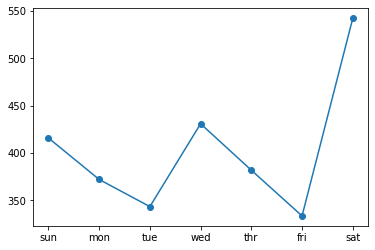

In [ ]:
# multivariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 50, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

# CNN-LSTM Encoder-Decoder Model With Univariate Input

* A convolutional neural network, or CNN, can be used as the encoder in an encoder-decoder architecture.

* The CNN does not directly support sequence input; instead, a 1D CNN is capable of reading across sequence input and automatically learning the salient features. These can then be interpreted by an LSTM decoder as per normal. We refer to hybrid models that use a CNN and LSTM as CNN-LSTM models, and in this case we are using them together in an encoder-decoder architecture.

* The CNN expects the input data to have the same 3D structure as the LSTM model, although multiple features are read as different channels that ultimately have the same effect.

* We will simplify the example and focus on the CNN-LSTM with univariate input, but it can just as easily be updated to use multivariate input, which is left as an exercise.

* As before, we will use input sequences comprised of 14 days of daily total power consumption.

* We will define a simple but effective CNN architecture for the encoder that is comprised of two convolutional layers followed by a max pooling layer, the results of which are then flattened.

* The first convolutional layer reads across the input sequence and projects the results onto feature maps. The second performs the same operation on the feature maps created by the first layer, attempting to amplify any salient features. We will use 64 feature maps per convolutional layer and read the input sequences with a kernel size of three time steps.

* The max pooling layer simplifies the feature maps by keeping 1/4 of the values with the largest (max) signal. The distilled feature maps after the pooling layer are then flattened into one long vector that can then be used as input to the decoding process.

lstm: [372.687] 385.0, 378.0, 336.4, 375.8, 365.0, 303.8, 448.6


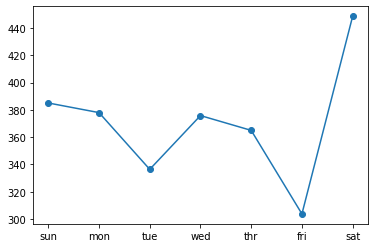

In [ ]:
# univariate multi-step encoder-decoder cnn-lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

# ConvLSTM Encoder-Decoder Model With Univariate Input

* A further extension of the CNN-LSTM approach is to perform the convolutions of the CNN (e.g. how the CNN reads the input sequence data) as part of the LSTM for each time step.

* This combination is called a Convolutional LSTM, or ConvLSTM for short, and like the CNN-LSTM is also used for spatio-temporal data.

* Unlike an LSTM that reads the data in directly in order to calculate internal state and state transitions, and unlike the CNN-LSTM that is interpreting the output from CNN models, the ConvLSTM is using convolutions directly as part of reading input into the LSTM units themselves.

lstm: [410.827] 413.9, 434.7, 374.3, 409.2, 388.7, 313.7, 513.9


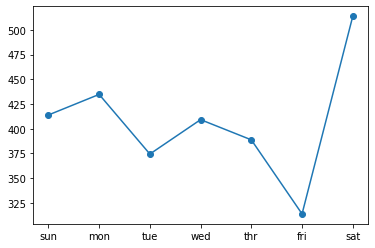

In [ ]:
# univariate multi-step encoder-decoder convlstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_steps, n_length, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape into subsequences [samples, time steps, rows, cols, channels]
	train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [samples, time steps, rows, cols, channels]
	input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input):
	# fit model
	model = build_model(train, n_steps, n_length, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# define the number of subsequences and the length of subsequences
n_steps, n_length = 2, 7
# define the total days to use as input
n_input = n_length * n_steps
score, scores = evaluate_model(train, test, n_steps, n_length, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

**we can extend our models that :**

* Size of Input: Explore more or fewer number of days used as input for the model, such as three days, 21 days, 30 days, and more.
* Model Tuning: Tune the structure and hyperparameters for a model and further lift model performance on average.
* Data Scaling: Explore whether data scaling, such as standardization and normalization, can be used to improve the performance of any of the LSTM models.
* Learning Diagnostics: Use diagnostics such as learning curves for the train and validation loss and mean squared error to help tune the structure and hyperparameters of a LSTM model.